In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import torch
import torch.utils.data as data 

from omegaconf import OmegaConf
from torchvision import transforms
from torch.nn.parallel import DistributedDataParallel as DDP
# 
from contrastive_learning.tests.test_model import load_lin_model, predict_traj_actions
from contrastive_learning.tests.animate_markers import AnimateMarkers
from contrastive_learning.tests.animate_rvec_tvec import AnimateRvecTvec
from contrastive_learning.datasets.dataloaders import get_dataloaders

from contrastive_learning.models.custom_models import LinearInverse
from contrastive_learning.datasets.state_dataset import StateDataset
from contrastive_learning.tests.test_data import plot_corners_state, plot_rvec_tvec, plot_corners

### Model Loading
Create the distributed group
Load the linear inverse model from the saved path

In [2]:
# Start the multiprocessing to load the saved models properly
os.environ["MASTER_ADDR"] = "localhost"
os.environ["MASTER_PORT"] = "29504"

torch.distributed.init_process_group(backend='gloo', rank=0, world_size=1)
torch.cuda.set_device(0)

In [3]:
# Set the device and out_dir
device = torch.device('cuda:0')
out_dir = '/home/irmak/Workspace/DAWGE/contrastive_learning/out/2022.07.21/15-35_pli_ue_False_lf_mse_fi_1_pt_corners_bs_64_hd_64_lr_0.001_zd_8'
cfg = OmegaConf.load(os.path.join(out_dir, '.hydra/config.yaml'))
model_path = os.path.join(out_dir, 'models/lin_model.pt')

# Load the encoder
lin_model = load_lin_model(cfg, device, model_path)

In [4]:
print(lin_model)

DistributedDataParallel(
  (module): LinearInverse(
    (model): Sequential(
      (0): Linear(in_features=32, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=16, bias=True)
      (3): ReLU()
      (4): Linear(in_features=16, out_features=2, bias=True)
    )
  )
)


### Action Animation
1. Dump every predicted action for given data directory
2. Save the predicted and current action in a video

In [5]:
demo_name = 'box_marker_35'
exp_name = out_dir.split('/')[-1]
data_dir = '/home/irmak/Workspace/DAWGE/src/dawge_planner/data/{}'.format(demo_name)
dump_dir = '/home/irmak/Workspace/DAWGE/contrastive_learning/tests/animations'
dump_file = '{}_{}.mp4'.format(demo_name, exp_name)

fps = 15

In [6]:
# Get the dataset
dataset = StateDataset(cfg, single_dir=True, single_dir_root=data_dir)
predicted_actions = np.zeros((len(dataset), 2))
test_loader = data.DataLoader(dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=4)

for i, batch in enumerate(test_loader):
    curr_pos, next_pos, action = [b.to(device) for b in batch]
    pred_action = lin_model(curr_pos, next_pos)

    print('Actual Action \t Predicted Action')
    for j in range(len(action)):
        print('{}, \t{}'.format(np.around(dataset.denormalize_action(action[j][0].cpu().detach().numpy()), 2),
                                          dataset.denormalize_action(pred_action[j][0].cpu().detach().numpy())))
        predicted_actions[i*cfg.batch_size+j,:] = dataset.denormalize_action(pred_action[j][0].cpu().detach().numpy())

with open(os.path.join(data_dir, 'predicted_actions.npy'), 'wb') as f:
    np.save(f, predicted_actions)

Actual Action 	 Predicted Action
[0.15 0.3 ], 	[0.15283934 0.31135734]
[ 0.  -0.3], 	[0.13480418 0.23921672]
[ 0.  -0.3], 	[0.11722616 0.16890465]
[0.15 0.3 ], 	[0.11251374 0.15005494]
[0.15 0.3 ], 	[0.12872431 0.21489724]
[0.15 0.3 ], 	[0.13049135 0.22196539]
[0.15 0.3 ], 	[0.13737644 0.24950574]
[0.15 0.3 ], 	[0.12616114 0.20464455]
[0.15 0.3 ], 	[0.11872223 0.1748889 ]
[0.15 0.3 ], 	[0.10311467 0.11245866]
[0.15 0.3 ], 	[0.09520897 0.08083588]
[ 0.  -0.3], 	[0.10428938 0.1171575 ]
[0.15 0.3 ], 	[0.09623475 0.08493898]
[0.15 0.3 ], 	[0.11712015 0.16848057]
[0.15 0.3 ], 	[0.10152035 0.10608141]
[0.15 0.3 ], 	[0.10998608 0.1399443 ]
[0.15 0.3 ], 	[0.11933899 0.17735596]
[ 0.  -0.3], 	[0.09619714 0.08478856]
[0.15 0.3 ], 	[0.09528185 0.08112738]
[0.15 0.3 ], 	[0.11115581 0.14462321]
[ 0.  -0.3], 	[0.10387005 0.11548019]
[0.15 0.3 ], 	[0.08366531 0.03466122]
[0.15 0.3 ], 	[0.10026634 0.10106535]
[ 0.  -0.3], 	[0.11038319 0.14153274]
[0.15 0.3 ], 	[0.07979944 0.01919775]
[0.15 0.3 ], 	[0.

min_x: -1.0, max_x: 987.0, min_y: -1.0, max_y: 699.0
Animation saved to: /home/irmak/Workspace/DAWGE/contrastive_learning/tests/animations/box_marker_35_15-35_pli_ue_False_lf_mse_fi_1_pt_corners_bs_64_hd_64_lr_0.001_zd_8.mp4


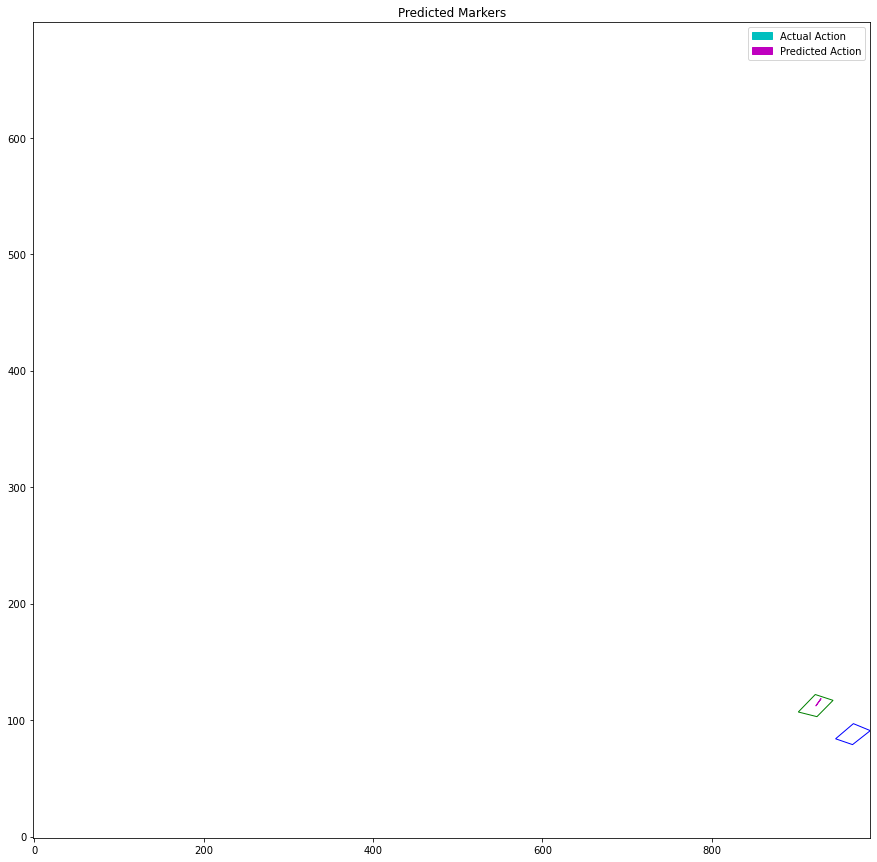

In [7]:

if cfg.pos_type == 'corners':
    AnimateMarkers(
        data_dir = data_dir, 
        dump_dir = dump_dir, 
        dump_file = dump_file, 
        fps = fps,
        mult_traj = False,
        show_predicted_action = True 
    ) # Saves them in the given dump_file
elif cfg.pos_type == 'rvec_tvec':
    AnimateRvecTvec(
        data_dir = data_dir, 
        dump_dir = dump_dir, 
        dump_file = dump_file,
        fps = fps,
        show_predicted_action=True
    )

### Action Prediction Image
Predict the action for each frame in the test dataset and dump them in a grid image

In [8]:
cfg.batch_size = 32
train_loader, test_loader, dataset = get_dataloaders(cfg)

In [9]:
len(test_loader.dataset)
batch = next(iter(test_loader))
curr_pos, next_pos, action = [b.to(device) for b in batch]
pred_action = lin_model(curr_pos, next_pos)

curr_pos.shape

torch.Size([32, 16])

In [10]:
print(curr_pos[0])

tensor([0.2718, 0.2864, 0.2906, 0.2608, 0.3176, 0.2751, 0.2988, 0.3006, 0.2310,
        0.3248, 0.2571, 0.3419, 0.2351, 0.3689, 0.2082, 0.3490],
       device='cuda:0')


In [43]:
import cv2
# Draw the boxes with the same way as rvec tvec plotting
def plot_corners(ax, curr_pos, use_img=False, img=None, plot_action=False, actions=None, color_scheme=1):
    # actions: [action, pred_action]
    if plot_action:
        action = actions[0]
        pred_action = actions[1]
        dir = 0
        pred_dir = 0
        action_pos = (1100,600)

    img_shape = (720, 1280, 3)
    blank_image = np.ones(img_shape, np.uint8) * 255
    if use_img == False: # use img is when two plots are drawn on top of each other
        img = ax.imshow(blank_image.copy())

    # Plot the boxed
    for j in range(2):
        curr_polygon = curr_pos[j*4:(j+1)*4,:]
#         print('curr_polygon.shape: {}'.format(curr_polygon.shape))
        if j == 0: # Show the box position
            if color_scheme == 1:
                box_color = (51,102,0)
            else:
                box_color = (102,204,0)

            frame_axis = cv2.polylines(blank_image.copy(), np.int32([curr_polygon.reshape((-1,1,2))]),
                                       isClosed=True, color=box_color, thickness=3)

        else:
            if color_scheme == 1:
                dog_color = (0,0,153)
            else:
                dog_color = (0,0,255)

            frame_axis = cv2.polylines(frame_axis.copy(), np.int32([curr_polygon.reshape((-1,1,2))]),
                                       isClosed=True, color=dog_color, thickness=3)

    if plot_action:
        # Actual action
        forward_speed = action[0]
        rotate_speed = action[1]
        dir -= rotate_speed
        action_x = forward_speed * math.sin(dir) * 500 # 250 is only for scaling
        action_y = forward_speed * math.cos(dir) * 500
        # action_arr = patches.Arrow(mean_x, mean_y, -action_x, -action_y, color='c', label='Actual Action') # - is for drawing purposes
        frame_axis = cv2.arrowedLine(frame_axis.copy(), action_pos,
                                        (int(action_pos[0]+action_x), int(action_pos[1]-action_y)), # Y should be removed from the action
                                        color=(0,200,200), thickness=3)

        
        # Draw an ellipse to show the rotate_speed more thoroughly
        ellipse_pos = (900,600)
        axesLength = (50, 50)
        angle = 0
        startAngle = 0
        endAngle = rotate_speed * (1080. / np.pi)
        # Using cv2.ellipse() method
        # Draw a ellipse with red line borders of thickness of 5 px
        frame_axis = cv2.ellipse(frame_axis.copy(), ellipse_pos, axesLength,
                angle, startAngle, endAngle, color=(0,200,200), thickness=3)


        # Predicted action
        ellipse_pos = (800,600)
        forward_speed = pred_action[0]
        rotate_speed = pred_action[1]
        endAngle = rotate_speed * (1080. / np.pi)
        pred_dir -= rotate_speed
        action_x = forward_speed * math.sin(pred_dir) * 500 # 250 is only for scaling
        action_y = forward_speed * math.cos(pred_dir) * 500
        frame_axis = cv2.arrowedLine(frame_axis.copy(), action_pos,
                                        (int(action_pos[0]+action_x), int(action_pos[1]-action_y)), # Y should be removed from the action
                                        color=(104,43,159), thickness=3)
        frame_axis = cv2.ellipse(frame_axis.copy(), ellipse_pos, axesLength,
                angle, startAngle, endAngle, color=(104,43,159), thickness=3)

    img.set_array(frame_axis) # If use_img is true then img will not be none
    ax.plot()

    return img

(4, 8)


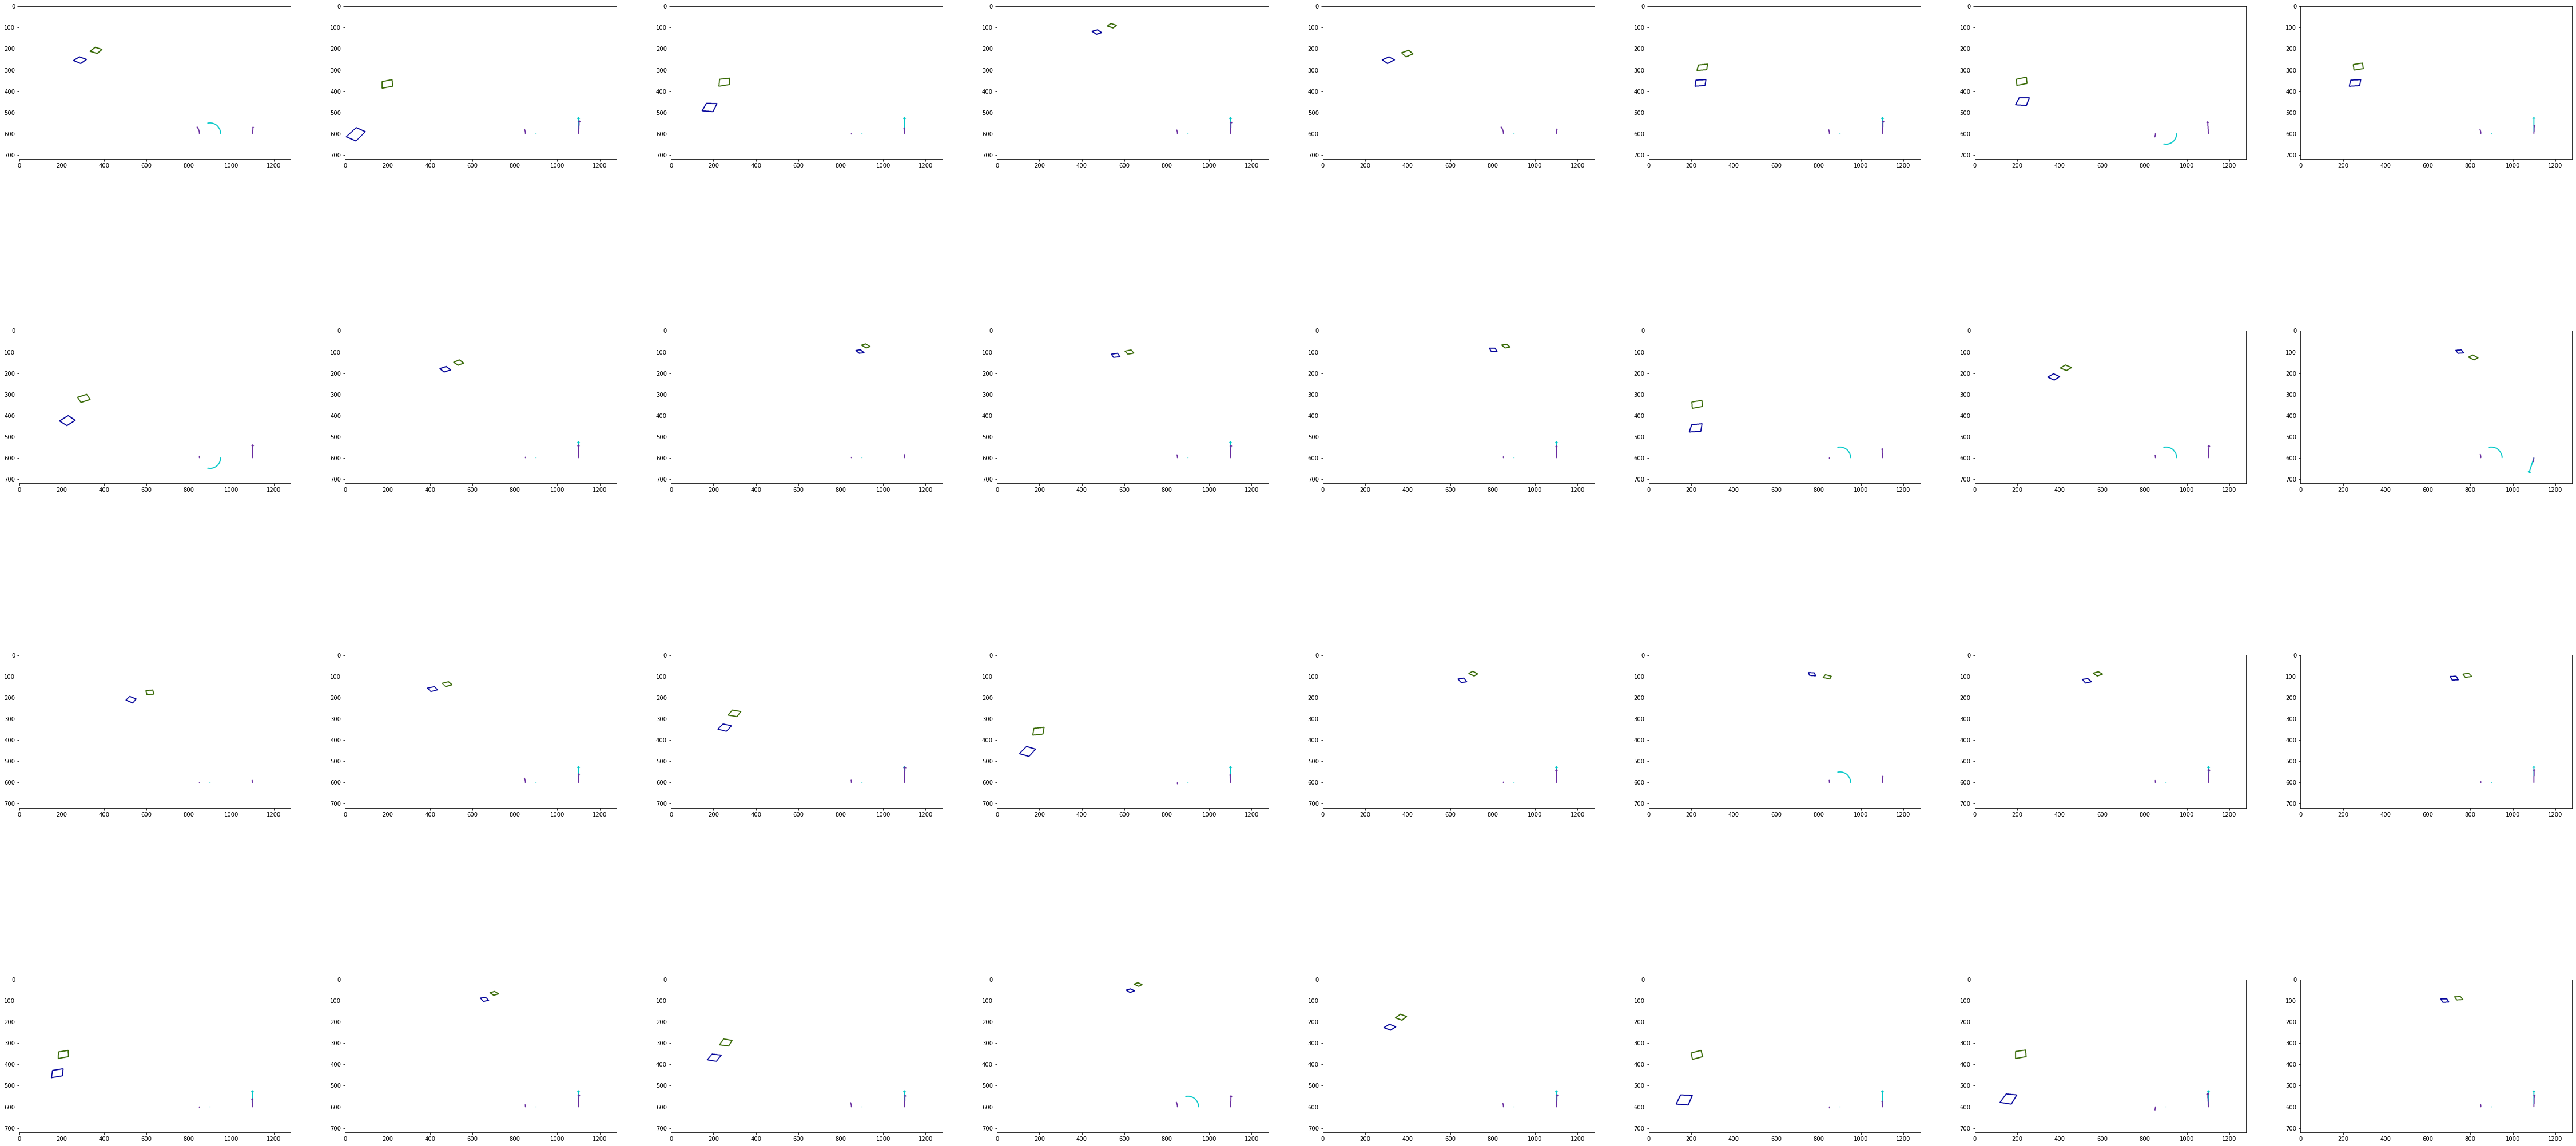

In [44]:
nrows = 4
ncols = int(cfg.batch_size / nrows)
fig, axs = plt.subplots(figsize=(ncols*10,nrows*10), nrows=nrows, ncols=ncols) # Draw the predicted action
print(axs.shape)

for i in range(cfg.batch_size):
    axs_row = int(i / nrows)
    axs_col = int(i % nrows)
    
    action_np = dataset.denormalize_action(action[i].cpu().detach().numpy())
    pred_action_np = dataset.denormalize_action(pred_action[i].cpu().detach().numpy())
    
    if cfg.pos_type == 'corners':
        curr_pos_np = dataset.denormalize_corner(curr_pos[i].cpu().detach().numpy())
#         plot_corners_state(
#             ax=axs[axs_col, axs_row],
#             curr_pos=curr_pos_np,
#             plot_action=True,
#             actions=(action_np, pred_action_np),
#             fps=15,
#             color_scheme=1)
        plot_corners(
            ax=axs[axs_col, axs_row],
            curr_pos=curr_pos_np,
            use_img=False,
            img=None,
            plot_action=True,
            actions=(action_np, pred_action_np))
    elif cfg.pos_type == 'rvec_tvec':
        curr_pos_np = dataset.denormalize_pos_rvec_tvec(curr_pos[i].cpu().detach().numpy())
        plot_rvec_tvec(
            ax=axs[axs_col, axs_row],
            curr_pos=curr_pos_np,
            use_img=False,
            img=None,
            plot_action=True,
            actions=(action_np, pred_action_np))
        
plt.savefig(os.path.join(out_dir, 'pil_action_test.jpg'))
    